In [85]:
import secrets
import pandas as pd
import numpy as np
#import seaborn as sns

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

from abc import ABC, abstractmethod
from dataclasses import dataclass

#sns.set(style="whitegrid")

In [86]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [87]:
import model.basic_model as basic_model
from model.stochastic_processes import (
    create_stochastic_process,
    plot_price,
)
from model.parts.init_stake import fetch_stake_data
from model.agents import (
    CEXAgent, LSTAgent, LRTAgent, SoloAgent, StakingPoolAgent, ETFAgent,
    StandardDeposit, StandardFullWithdraw
)
import model.agents_decision as agents_decision
import model.infra_costs as infra_costs
import model.APY as APY

from config import TIMESTEPS

In [88]:
# types
Run = int
Timestep = TIMESTEPS

# Price Traj Generation

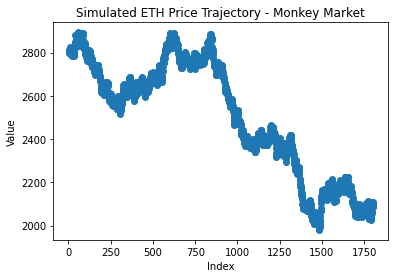

1980.0504461440564


In [89]:
eth_price_samples = create_stochastic_process(timesteps=Timestep,price_traj_type = 'concave')
eth_price_samples = [i for i in eth_price_samples] # ETH-USD pair
plot_price(eth_price_samples, 'Monkey Market') 
print(min(eth_price_samples))

# Setup

In [90]:
constants = {
}

In [91]:
recent_staked = fetch_stake_data()
curr_stake_LRT = recent_staked[recent_staked['entity_category']=='Liquid Restaking']['amount_staked']
curr_stake_LST = recent_staked[recent_staked['entity_category']=='Liquid Staking']['amount_staked']
curr_stake_CEX = recent_staked[recent_staked['entity_category']=='CEXs']['amount_staked']
curr_stake_Solo = recent_staked[recent_staked['entity_category']=='Solo Stakers']['amount_staked']
curr_stake_SP = recent_staked[recent_staked['entity_category']=='Staking Pools']['amount_staked']
curr_stake_Unidentified = recent_staked[recent_staked['entity_category']=='Unidentified']['amount_staked']

In [92]:
recent_staked

entity_category  amount_staked
0              CEXs   8.428639e+06
1  Liquid Restaking   2.831248e+06
2    Liquid Staking   1.106258e+07
3      Solo Stakers   3.402329e+05
4     Staking Pools   5.903047e+06
5      Unidentified   6.280785e+06

In [93]:
# Initialize an agent
cex_agent = CEXAgent(
    balance=curr_stake_CEX, 
    cnt=int(curr_stake_CEX/32), 
    category="CEX", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lst_agent = LSTAgent(
    balance=curr_stake_LST, 
    cnt=int(curr_stake_LST/32), 
    category="LST", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lrt_agent = LRTAgent(
    balance=curr_stake_LRT, 
    cnt=int(curr_stake_LRT/32), 
    category="LRT", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

solo_agent = SoloAgent(
    balance=curr_stake_Solo, 
    cnt=int(curr_stake_Solo/32), 
    category="Solo", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

sp_agent = StakingPoolAgent(
    balance=curr_stake_SP, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

etf_agent = ETFAgent(
    balance=0, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

<ipython-input-93-f3800099faa3>:4: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

<ipython-input-93-f3800099faa3>:16: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

<ipython-input-93-f3800099faa3>:28: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

<ipython-input-93-f3800099faa3>:40: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

<ipython-input-93-f3800099faa3>:52: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

<ipython-input-93-f3800099faa3>:64: FutureWarning:

Calling int on a single element Series is deprecated and will ra

# Simulation

In [94]:
ETH_initial_price = eth_price_samples[0]
agents = {
        "CEXAgent": cex_agent,
        "LSTAgent": lst_agent,
        "LRTAgent": lrt_agent,
        "SoloAgent": solo_agent,
        "StakingPoolAgent": sp_agent,
    }

In [95]:
@dataclass
class MVIParams:

    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    opportunity_cost: List[float] = default([0.02])

    revenue_baseline_reduction: List[float] = default([0.005])
    mev_and_priority_add: List[float] = default([0.005])
    revenue_adjustment_beta: List[float] = default([1.0])

parameters = MVIParams().__dict__

In [96]:
psub = [{
    "policies": {
    },
    "variables": {
        "timestep": basic_model.update_timestep,
        "price": basic_model.update_price,
    }
},  { 
    "policies": {
        "action": agents_decision.deposit_withdraw
    },
    "variables": {
        "CEXAgent": agents_decision.update_CEXAgent_deposit_withdraw,
        "LSTAgent": agents_decision.update_LSTAgent_deposit_withdraw,
        "LRTAgent": agents_decision.update_LRTAgent_deposit_withdraw,
        "SoloAgent": agents_decision.update_SoloAgent_deposit_withdraw,
        "StakingPoolAgent": agents_decision.update_StakingPoolAgent_deposit_withdraw,
    }
},  { # TODO: double check the infra costs
    "policies": { 
        "action": infra_costs.calc_costs
    },
    "variables": {
        "CEXAgent": infra_costs.update_CEXAgent_cost,
        "LSTAgent": infra_costs.update_LSTAgent_cost,
        "LRTAgent": infra_costs.update_LRTAgent_cost,
        "SoloAgent": infra_costs.update_SoloAgent_cost,
        "StakingPoolAgent": infra_costs.update_StakingPoolAgent_cost,
    }
},  { 
    "policies": {
        "action": APY.calc_decentralization_and_total_staked
    },
    "variables": {
        "total_staked": APY.update_total_staked,
        "total_validator_cnt": APY.update_total_validator_cnt,
        "decentralization_metrics": APY.update_decentralization_metrics,
    }
}, { 
    "policies": {
        "action": APY.calc_issuance_APR
    },
    "variables": {
        "issuance_APR": APY.update_issuance_APR
    }
}, { 
    "policies": {
        "action": APY.calc_revenue_APY
    },
    "variables": {
        "revenue_APY": APY.update_revenue_APY,
        "revenue_APY_at_agent": APY.update_revenue_APY_at_agent
    }
}
]

initial_conditions = {
    "timestep": 0,
    "price": ETH_initial_price, 
    "CEXAgent": cex_agent,
    "LSTAgent": lst_agent,
    "LRTAgent": lrt_agent,
    "SoloAgent": solo_agent,
    "StakingPoolAgent": sp_agent,
    "ETFAgent": etf_agent,
    "total_staked": 0,
    "total_validator_cnt": 0,
    "decentralization_metrics": {},
    "issuance_APR": 0.0,
    "revenue_APY": 0.0,
    "revenue_APY_at_agent": {
        "CEXAgent": 0.0,
        "LSTAgent": 0.0,
        "LRTAgent": 0.0,
        "SoloAgent": 0.0,
        "StakingPoolAgent": 0.0
        }
}


params = parameters

model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params,
    )

In [97]:
simulation = Simulation(model=model, timesteps=Timestep, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results = experiment.run()
df = pd.DataFrame(results)

2024-10-29 21:56:22,256 INFO root Starting simulation 0 / run 0 / subset 0


In [98]:
df

timestep        price  \
0             0  2800.299693   
1             1  2800.299693   
2             1  2800.299693   
3             1  2800.299693   
4             1  2800.299693   
...         ...          ...   
10796      1800  2093.577631   
10797      1800  2093.577631   
10798      1800  2093.577631   
10799      1800  2093.577631   
10800      1800  2093.577631   

                                                CEXAgent  \
0      CEXAgent(balance=0    8.428639e+06\nName: amou...   
1      CEXAgent(balance=0    8.428639e+06\nName: amou...   
2      CEXAgent(balance=0    8.432066e+06\nName: amou...   
3      CEXAgent(balance=0    8.432066e+06\nName: amou...   
4      CEXAgent(balance=0    8.432066e+06\nName: amou...   
...                                                  ...   
10796  CEXAgent(balance=0    1.379524e+07\nName: amou...   
10797  CEXAgent(balance=0    1.379524e+07\nName: amou...   
10798  CEXAgent(balance=0    1.379524e+07\nName: amou...   
10799  CEXAgent(balance=0    1.379524e+07\nName: amou...   
10800  CEXAgent(balance=0    1.379524e+07\nName: amou...   

                                                LSTAgent  \
0      LSTAgent(balance=2    1.106258e+07\nName: amou...   
1      LSTAgent(balance=2    1.106258e+07\nName: amou...   
2      LSTAgent(balance=2    1.106490e+07\nName: amou...   
3      LSTAgent(balance=2    1.106490e+07\nName: amou...   
4      LSTAgent(balance=2    1.106490e+07\nName: amou...   
...                                                  ...   
10796  LSTAgent(balance=2    1.513214e+07\nName: amou...   
10797  LSTAgent(balance=2    1.513214e+07\nName: amou...   
10798  LSTAgent(balance=2    1.513214e+07\nName: amou...   
10799  LSTAgent(balance=2    1.513214e+07\nName: amou...   
10800  LSTAgent(balance=2    1.513214e+07\nName: amou...   

                                                LRTAgent  \
0      LRTAgent(balance=1    2.831248e+06\nName: amou...   
1      LRTAgent(balance=1    2.831248e+06\nName: amou...   
2      LRTAgent(balance=1    2.831248e+06\nName: amou...   
3      LRTAgent(balance=1    2.831248e+06\nName: amou...   
4      LRTAgent(balance=1    2.831248e+06\nName: amou...   
...                                                  ...   
10796  LRTAgent(balance=1    8.364646e+06\nName: amou...   
10797  LRTAgent(balance=1    8.364646e+06\nName: amou...   
10798  LRTAgent(balance=1    8.364646e+06\nName: amou...   
10799  LRTAgent(balance=1    8.364646e+06\nName: amou...   
10800  LRTAgent(balance=1    8.364646e+06\nName: amou...   

                                               SoloAgent  \
0      SoloAgent(balance=3    340232.899814\nName: am...   
1      SoloAgent(balance=3    340232.899814\nName: am...   
2      SoloAgent(balance=3    340314.4996\nName: amou...   
3      SoloAgent(balance=3    340314.4996\nName: amou...   
4      SoloAgent(balance=3    340314.4996\nName: amou...   
...                                                  ...   
10796  SoloAgent(balance=3    407204.956086\nName: am...   
10797  SoloAgent(balance=3    407204.956086\nName: am...   
10798  SoloAgent(balance=3    407204.956086\nName: am...   
10799  SoloAgent(balance=3    407204.956086\nName: am...   
10800  SoloAgent(balance=3    407204.956086\nName: am...   

                                        StakingPoolAgent  \
0      StakingPoolAgent(balance=4    5.903047e+06\nNa...   
1      StakingPoolAgent(balance=4    5.903047e+06\nNa...   
2      StakingPoolAgent(balance=4    5.906213e+06\nNa...   
3      StakingPoolAgent(balance=4    5.906213e+06\nNa...   
4      StakingPoolAgent(balance=4    5.906213e+06\nNa...   
...                                                  ...   
10796  StakingPoolAgent(balance=4    1.248080e+07\nNa...   
10797  StakingPoolAgent(balance=4    1.248080e+07\nNa...   
10798  StakingPoolAgent(balance=4    1.248080e+07\nNa...   
10799  StakingPoolAgent(balance=4    1.248080e+07\nNa...   
10800  StakingPoolAgent(balance=4    1.248080e+07\nNa...   

                 

In [99]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
    0: "normal",
}
)

In [100]:
visualizations.plot_total_staked(
    df,
    scenario_names={
    0: "normal",
}
)

In [101]:
visualizations.plot_hhi(
    df,
    scenario_names={
    0: "normal",
}
)

In [102]:
visualizations.plot_cost_APY_for_agents(df, ['StakingPoolAgent', 'SoloAgent'])


In [103]:
visualizations.plot_revenue_APY_for_agents(df, agents)

      timestep  CEXAgent  LSTAgent  LRTAgent  SoloAgent  StakingPoolAgent
0            2  1.932452  2.387628  2.172786   2.081590          2.136873
1            3  1.932033  2.387083  2.172312   2.081446          2.137001
2            4  1.931616  2.386554  2.171856   2.080597          2.136129
3            5  1.931204  2.386032  2.171399   2.079225          2.134509
4            6  1.930813  2.385527  2.170946   2.079022          2.134523
...        ...       ...       ...       ...        ...               ...
1794      1796  1.475778  1.792443  1.683804   1.378976          1.451321
1795      1797  1.475664  1.792289  1.683634   1.380783          1.453962
1796      1798  1.475434  1.791992  1.683434   1.381612          1.455254
1797      1799  1.475316  1.791841  1.683262   1.381395          1.455040
1798      1800  1.475192  1.791685  1.683083   1.378923          1.451655

[1799 rows x 6 columns]


In [104]:
visualizations.plot_balance_for_agents(df, agents)

In [105]:
visualizations.plot_avg_revenue_APY(
    df,
    scenario_names={
    0: "normal",
}
)